In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import FastICA
from sklearn.utils.class_weight import compute_class_weight

import torch
from torchvision import models
import torchvision.transforms as transforms
from skimage.color import rgb2gray

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


__Processing__

In [12]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list
 

def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img_list):
    shape = img_list.shape
    new_arr = np.zeros(shape=shape)
    new_list = []
    for i, img in enumerate(img_list):
        if len(new_list) == 3:
            new_list = []
        v = np.median(img)
        sigma = 0.33


        if img.dtype != 'uint8':
            img = img.astype('uint8')

        img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(max(0, (1.0 + sigma) * v))

        img = cv2.Canny(img, lower, upper)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        new_list.append(img)
        if len(new_list) == 3:
            new_arr[i] = img

    # print(new_list)
    return new_arr

def find_edge(img):
    v = np.median(img)
    sigma = 0.33

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(max(0, (1.0 + sigma) * v))

    img = cv2.Canny(img, lower, upper)
    
    return img

def get_features(image_list):
    for i in range(len(image_list)):
        img_rgb = image_list[i]  # RGB image
        img_gray = rgb2gray(img_rgb)  # Convert to grayscale
        image_list[i] = (img_gray * 255).astype('uint8')
    feature_list = []

    distances = [1,3,5,9]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

    properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

    # need to add more distances (1,3,5,9)
    for n, img in enumerate(image_list):
        glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
        feature_row = {}

        for prop in properties:
            prop_values = graycoprops(glcm, prop)   
            for i, dist in enumerate(distances):
                for j, angle in enumerate(angles): 
                    feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                    feature_row[feature_name] = prop_values[i, j]

        feature_list.append(feature_row)
    return feature_list

def view_corr(df):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix)
    plt.show()

def pca_df_pick_comp(df):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)

    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

    pca_tot = pca_df
    plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
    plt.xlabel("Num of components")
    plt.ylabel('Cumulative exlpained by variance')
    plt.title('explained variance by pca components')
    plt.show()

    cumulative_var = pca.explained_variance_ratio_.cumsum()
    n_components = 0

    for i, var in enumerate(cumulative_var):
        if var >= 0.95:
            n_components = i + 1
            break

    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)

    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    pca_df= pd.DataFrame(reduced_features, columns=pca_columns)

    return pca_df, pca_tot

    


In [13]:
def load_images_resnet(dir_name):

    img = cv2.imread(dir_name)

    img = find_edge(img)
    img = cv2.GaussianBlur(img, (5,5), 1)

    #might need to add clahe
   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = img / 255

   

    #normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img-mean) / std
    img = np.transpose(img, (2, 0 , 1))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    return img_tensor

def extract_features_resnet(dir_name, model):
   
    img_tensor = load_images_resnet(dir_name)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()

In [67]:
def find_edge(img):
    # Placeholder for edge detection logic (if necessary)
    return img

def load_images_resnet(dir_name):
    # Read the image
    img = cv2.imread(dir_name)

    # Apply edge detection (if required)
    img = find_edge(img)
    img = cv2.GaussianBlur(img, (5, 5), 1)

    # Resize to 224x224
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = img / 255.0

    # Normalize image using ImageNet mean and std (per channel)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Apply normalization across the 3 channels (HWC format)
    img = (img - mean) / std  # Broadcasting will apply to each channel

    # Convert from HWC to CHW format (for PyTorch) - this will be used for PyTorch models
    img_tensor = np.transpose(img, (2, 0, 1))  # Shape will be (3, 224, 224)
    
    # Convert to tensor (PyTorch format)
    img_tensor = torch.tensor(img_tensor, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return img_tensor



In [15]:
dir_name = "../pca/data_xray/Impacted fracture"

list_1 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_1.append(feature)

for i in range(len(list_1)):
    img_tensor = list_1[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    img = img_tensor.numpy()
    list_1[i] = img
# plt.imshow(list_1[7], cmap='gray')
# print((list_1[8].shape))

In [16]:
dir_name = "../pca/data_xray/Intra-articular fracture"
list_2 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_2.append(feature)

for i in range(len(list_2)):
    img_tensor = list_2[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_2[i] = img
# plt.imshow(list_2[7], cmap='gray')
# print(len(list_2))

In [69]:
dir_name = "../pca/data_xray/Longitudinal fracture"
list_3 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_3.append(feature)

for i in range(len(list_3)):
    img_tensor = list_3[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_3[i] = img
# plt.imshow(list_3[7])
# print(len(list_3))

In [68]:
dir_name = "../pca/data_xray/Oblique fracture"
list_4 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_4.append(feature)

for i in range(len(list_4)):
    img_tensor = list_4[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_4[i] = img
# plt.imshow(list_4[7], cmap='gray')
# print(len(list_4))

In [19]:
list_1 = get_features(list_1)
list_2 = get_features(list_2)
list_3 = get_features(list_3)
list_4 = get_features(list_4)

In [ ]:
impacted = pd.DataFrame(list_1)
impacted['target'] = 0

intra_artic = pd.DataFrame(list_2)
intra_artic['target'] = 1

longitudinal = pd.DataFrame(list_3)
longitudinal['target'] = 2

oblique =  pd.DataFrame(list_4)
oblique['target'] = 3

data_df_resnet = pd.concat([impacted,intra_artic,longitudinal,oblique], axis=0)
X = data_df_resnet.iloc[:, :-1]
Y = data_df_resnet.iloc[:, -1]

print(impacted.shape, intra_artic.shape, longitudinal.shape, oblique.shape)


(316, 141) (130, 141) (76, 141) (29, 141)


**Train a CNN to classify the models**

This will then be put into the resnet, replacing a few layers of it to make it better suited for our cause


In [24]:
data = tf.keras.utils.image_dataset_from_directory('../pca/data_xray')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
data = data.map(lambda x,y: (x/255, y))
#scales the data, make it easier to process
train_size = int(len(data)*.6)
    #70% of the data for training, 123 batches
val_size = int(len(data)*.2)
    #used during training, 35 batches
test_size = int(len(data)*.2)
    #used post training, 17 batches
print(f'train size: {train_size} batches \n'
      f'val size: {val_size} batches \n'
      f'test size: {test_size} batches')
data.as_numpy_iterator().next();
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

def extract_images_and_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert the batch of images to numpy
        labels.append(label_batch.numpy())  # Convert the batch of labels to numpy
    images = np.concatenate(images, axis=0)  # Concatenate all batches to form a single numpy array
    labels = np.concatenate(labels, axis=0)  # Concatenate all labels
    images = find_edges(images)
    return images, labels

# Extract data for train, validation, and test
x_train, y_train = extract_images_and_labels(train)
x_val, y_val = extract_images_and_labels(val)
x_test, y_test = extract_images_and_labels(test)

# Print the shapes to confirm the data is extracted correctly
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

Found 551 files belonging to 4 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
train size: 10 batches 
val size: 3 batches 
test size: 3 batches
x_train shape: (320, 256, 256, 3), y_train shape: (320,)
x_val shape: (96, 256, 256, 3), y_val shape: (96,)
x_test shape: (96, 256, 256, 3), y_test shape: (96,)


In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()


y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

print(y_train.sum(axis = 0))
print(y_val.sum(axis = 0))
print(y_test.sum(axis = 0))

[180.  82.  42.  16.]
[50. 27. 13.  6.]
[58. 20. 16.  2.]


**CNN using log**

run one or the other, not both, will occupy same variable

In [26]:
# logdir='log'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_val,y_val), callbacks=[tensorboard_callback])

**CNN using class_weights**
heavily considers the fact that there is substancial more data in class 0 than the rest

In [27]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_df_resnet['target']),
    y=data_df_resnet['target']
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)
class_weight_list = list(class_weights_dict)

hist = model.fit(x_train, y_train,validation_data= (x_val,y_val),epochs = 9, class_weight=class_weights_dict)

{0: 0.43591772151898733, 1: 1.0596153846153846, 2: 1.8125, 3: 4.75}
Epoch 1/9
10/10 [==============================] - 12s 1s/step - loss: 2.9871 - accuracy: 0.2719 - val_loss: 1.5906 - val_accuracy: 0.2708
Epoch 2/9
10/10 [==============================] - 11s 1s/step - loss: 1.4157 - accuracy: 0.3000 - val_loss: 1.3944 - val_accuracy: 0.2708
Epoch 3/9
10/10 [==============================] - 11s 1s/step - loss: 1.2955 - accuracy: 0.3531 - val_loss: 1.3708 - val_accuracy: 0.2708
Epoch 4/9
10/10 [==============================] - 9s 895ms/step - loss: 1.2471 - accuracy: 0.3875 - val_loss: 1.3845 - val_accuracy: 0.2708
Epoch 5/9
10/10 [==============================] - 9s 905ms/step - loss: 1.1821 - accuracy: 0.4125 - val_loss: 1.4427 - val_accuracy: 0.3125
Epoch 6/9
10/10 [==============================] - 9s 921ms/step - loss: 1.1247 - accuracy: 0.4187 - val_loss: 1.7332 - val_accuracy: 0.2604
Epoch 7/9
10/10 [==============================] - 9s 935ms/step - loss: 1.0775 - accuracy: 

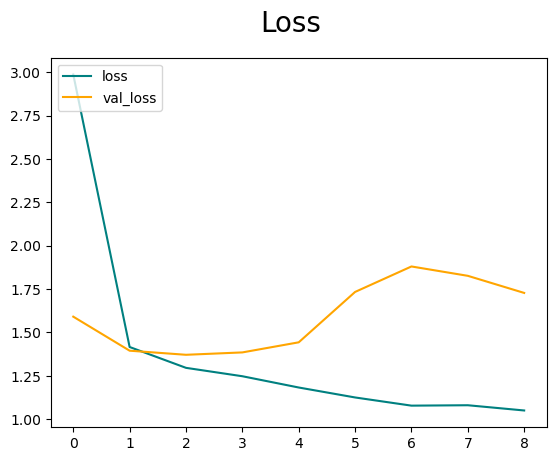

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

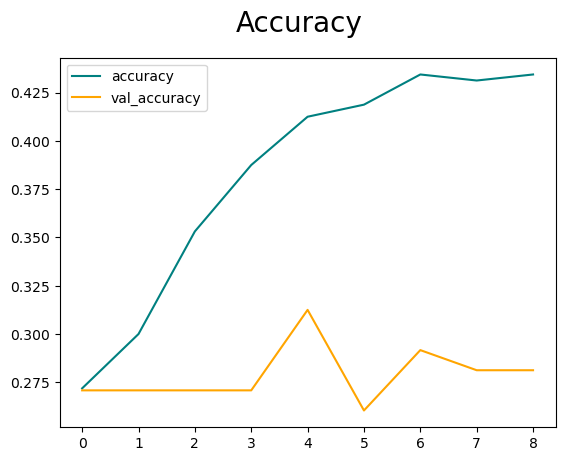

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [30]:
def test_function(location):
    img = x_test[location]
    true_label = y_test[location]

    resize = tf.image.resize(np.expand_dims(img, 0), (256, 256))
    yhat = model.predict(resize / 255.0)
    predicted_class = np.argmax(yhat, axis=-1)[0]
    class_names = ['Impacted Fracture', 'Intra-Articular Fracture', 'Longitudinal Fracture', 'Oblique Fracture']
    print(f'Predicted class: {class_names[predicted_class]}')

    
    true_class = np.argmax(true_label)
    print(f'True class: {class_names[true_class]}')

    if class_names[predicted_class] == class_names[true_class]:
        # print('Correct')
        count = 1
    else:
        # print('Incorrect')
        count = 0
    return count

    # plt.imshow(img)
    # plt.axis('off')
    # plt.show()

In [31]:
val = 0
for i in range(len(y_test)):
    counter = test_function(i);
    val += counter


1/1 [==============================] - 0s 345ms/step
Predicted class: Intra-Articular Fracture
True class: Longitudinal Fracture
1/1 [==============================] - 0s 41ms/step
Predicted class: Intra-Articular Fracture
True class: Intra-Articular Fracture
1/1 [==============================] - 0s 41ms/step
Predicted class: Intra-Articular Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 41ms/step
Predicted class: Intra-Articular Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 40ms/step
Predicted class: Intra-Articular Fracture
True class: Intra-Articular Fracture
1/1 [==============================] - 0s 39ms/step
Predicted class: Intra-Articular Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 39ms/step
Predicted class: Intra-Articular Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 39ms/step
Predicted class: Intra-Articular Fracture
True class: Longitu

In [32]:
print(val)
y_test.sum(axis = 0)
print(y_test.sum(axis = 0))


22
[58. 20. 16.  2.]


**Resnet Section**

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model

In [62]:
from tensorflow.keras.layers import Reshape

def next_layer(base_output):
    x = GlobalAveragePooling2D()(base_output)
    x = Reshape((1, 1, -1))(x)  # Reshape into 4D tensor (batch_size, 1, 1, channels)
    
    x = Conv2D(16, (1, 1), activation='relu', padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='softmax')(x)
    return x


In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '../pca/data_xray',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../pca/data_xray',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 442 images belonging to 4 classes.
Found 109 images belonging to 4 classes.


In [65]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = next_layer(base_model.output)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=10)#, class_weight = class_weights_dict)



Epoch 1/10
14/14 [==============================] - 68s 5s/step - loss: 1.4318 - accuracy: 0.2217 - val_loss: 1.4598 - val_accuracy: 0.0459
Epoch 2/10
14/14 [==============================] - 63s 5s/step - loss: 1.3964 - accuracy: 0.2308 - val_loss: 1.4320 - val_accuracy: 0.1193
Epoch 3/10
14/14 [==============================] - 63s 5s/step - loss: 1.3902 - accuracy: 0.2262 - val_loss: 1.4695 - val_accuracy: 0.0459
Epoch 4/10
14/14 [==============================] - 65s 5s/step - loss: 1.3943 - accuracy: 0.2104 - val_loss: 1.5103 - val_accuracy: 0.2385
Epoch 5/10
14/14 [==============================] - 64s 5s/step - loss: 1.3930 - accuracy: 0.1991 - val_loss: 1.4771 - val_accuracy: 0.0550
Epoch 6/10
14/14 [==============================] - 67s 5s/step - loss: 1.3888 - accuracy: 0.2127 - val_loss: 1.4660 - val_accuracy: 0.1927
Epoch 7/10
14/14 [==============================] - 64s 5s/step - loss: 1.3825 - accuracy: 0.2398 - val_loss: 1.4845 - val_accuracy: 0.0459
Epoch 8/10
14/14 [==

In [66]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = next_layer(base_model.output)

predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = predictions)

for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True
optimizer = keras.optimizers.Adam(learning_rate=0.002)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_generator, validation_data=val_generator, epochs=10, class_weight = class_weights_dict)



Epoch 1/10
14/14 [==============================] - 72s 5s/step - loss: 1.4283 - accuracy: 0.1154 - val_loss: 1.4117 - val_accuracy: 0.5780
Epoch 2/10
14/14 [==============================] - 66s 5s/step - loss: 1.3942 - accuracy: 0.2059 - val_loss: 1.4063 - val_accuracy: 0.5780
Epoch 3/10
14/14 [==============================] - 64s 5s/step - loss: 1.3849 - accuracy: 0.2670 - val_loss: 1.4043 - val_accuracy: 0.5780
Epoch 4/10
14/14 [==============================] - 61s 4s/step - loss: 1.3499 - accuracy: 0.3213 - val_loss: 1.4007 - val_accuracy: 0.5780
Epoch 5/10
14/14 [==============================] - 62s 4s/step - loss: 1.3406 - accuracy: 0.3575 - val_loss: 1.3983 - val_accuracy: 0.5780
Epoch 6/10
14/14 [==============================] - 68s 5s/step - loss: 1.3316 - accuracy: 0.3235 - val_loss: 1.3924 - val_accuracy: 0.5780
Epoch 7/10
14/14 [==============================] - 64s 5s/step - loss: 1.3287 - accuracy: 0.1900 - val_loss: 1.3917 - val_accuracy: 0.1376
Epoch 8/10
14/14 [==